Using TensorFlow backend.



Train Data
       bbox_x1  bbox_y1  bbox_x2  bbox_y2  class      fname
0          39      116      569      375     14  00001.jpg
1          36      116      868      587      3  00002.jpg
2          85      109      601      381     91  00003.jpg
3         621      393     1484     1096    134  00004.jpg
4          14       36      133       99    106  00005.jpg
...       ...      ...      ...      ...    ...        ...
8139        3       44      423      336     78  08140.jpg
8140      138      150      706      523    196  08141.jpg
8141       26      246      660      449    163  08142.jpg
8142       78      526     1489      908    112  08143.jpg
8143       20      240      862      677     17  08144.jpg

[8144 rows x 6 columns]

Test Data
       bbox_x1  bbox_y1  bbox_x2  bbox_y2      fname
0          30       52      246      147  00001.jpg
1         100       19      576      203  00002.jpg
2          51      105      968      659  00003.jpg
3          67       84      581   

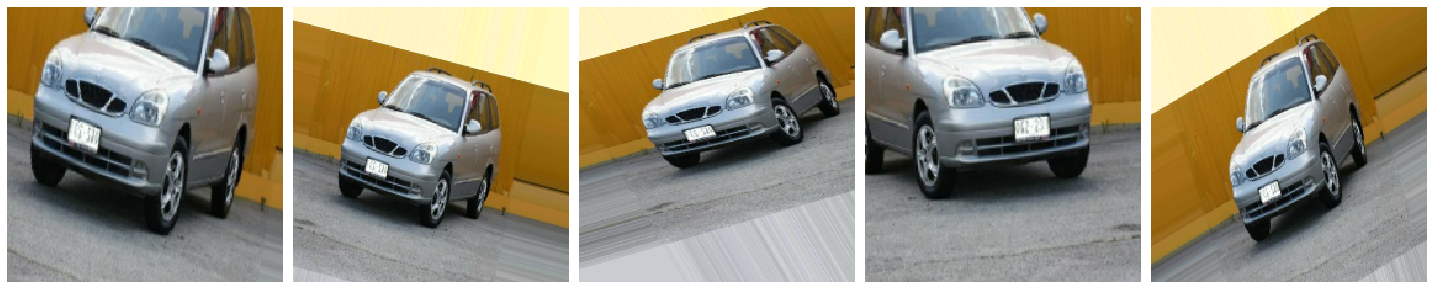

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
import keras
import os, sys
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd
import numpy as np


# Define train data
columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class', 'fname']
train_images_dir = os.path.join('./', 'cars_train')
train_labels_mat = scipy.io.loadmat('cars_train_annos.mat')
train_labels_data = [[row.flat[0] for row in line] for line in train_labels_mat['annotations'][0]]
df_train = pd.DataFrame(train_labels_data, columns=columns)
print("\n================================\nTrain Data\n================================\n", df_train)

# Define test data
columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'fname']
test_images_dir = os.path.join('./', 'cars_test')
test_labels_mat = scipy.io.loadmat('cars_test_annos.mat')
test_labels_data = [[row.flat[0] for row in line] for line in test_labels_mat['annotations'][0]]
df_test = pd.DataFrame(test_labels_data, columns=columns) 
print("\n================================\nTest Data\n================================\n", df_test)

# Try out CNN
batch_size = 16
epochs = 15
IMG_HEIGHT = 224
IMG_WIDTH = 224

#Rescale the images
train_image_generator = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=45,
                            width_shift_range=.15,
                            height_shift_range=.15,
                            horizontal_flip=True,
                            zoom_range=0.5
                        )

test_image_generator = ImageDataGenerator(rescale=1./255)

# Run images through the image generators
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_images_dir,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           shuffle=True,
                                                           class_mode='categorical')

test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                             directory=test_images_dir,
                                                             target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                             class_mode='categorical')

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)



In [2]:
# VGG-16.
model = Sequential([
Conv2D(64, (3, 3), input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), padding="same", activation="relu"),
Conv2D(64, (3, 3), activation="relu", padding="same"),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
Conv2D(128, (3, 3), activation="relu", padding="same"),
Conv2D(128, (3, 3), activation="relu", padding="same",),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
Conv2D(256, (3, 3), activation="relu", padding="same",),
Conv2D(256, (3, 3), activation="relu", padding="same",),
Conv2D(256, (3, 3), activation="relu", padding="same",),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
Conv2D(512, (3, 3), activation="relu", padding="same",),
Conv2D(512, (3, 3), activation="relu", padding="same",),
Conv2D(512, (3, 3), activation="relu", padding="same",),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
Conv2D(512, (3, 3), activation="relu", padding="same",),
Conv2D(512, (3, 3), activation="relu", padding="same",),
Conv2D(512, (3, 3), activation="relu", padding="same",),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
Flatten(),
Dense(4096, activation="relu"),
Dense(4096, activation="relu"),
Dense(196, activation="softmax")
])

# Complile model 
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# View all of the layers of the network
model.summary()

logger = keras.callbacks.TensorBoard(log_dir="vgg16_1", write_graph=True, histogram_freq=5)

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=6114 // batch_size,
    epochs=epochs,
    validation_data=test_data_gen,
    validation_steps=2000 // batch_size,
    callbacks=[logger],
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       2

## Transfer learning VGG16 imagenet

In [ ]:


model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))


# Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
for layer in model.layers[:5]:
    layer.trainable = False

#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(196, activation="softmax")(x)

# creating the final model 
model_final = Model(input = model.input, output = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

# Save the model according to the conditions  
checkpoint = ModelCheckpoint("vgg16_2.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

logger = keras.callbacks.TensorBoard(log_dir="vgg16_2", write_graph=True, histogram_freq=5)

# Initiate the train and test generators with data Augumentation 
train_image_generator = ImageDataGenerator(
                            rescale=1./255,
                        )

test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_images_dir,
                                                           target_size=(img_height, img_width),
                                                           shuffle=True,
                                                           class_mode='categorical')

test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                             directory=test_images_dir,
                                                             target_size=(img_height, img_width),
                                                             class_mode='categorical')

# Train the model 
model_final.fit_generator(
train_data_gen,
steps_per_epoch=6114 // batch_size,
epochs = epochs,
validation_data = test_data_gen,
validation_steps=2000 // batch_size,
callbacks = [checkpoint, early, logger])